# State estimation with unknown $\mathbf{A}$
State space model
\begin{align*}
    &\mathbf{x}_n = \mathbf{A}\mathbf{x}_{n-1} + \mathbf{n} \quad \mathbf{n} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}\gamma_x^{-1}) \\
    &y_n = \mathbf{c}^\text{T}\mathbf{x}_n + v \quad v \sim \mathcal{N}(0, \gamma_y^{-1})
\end{align*}

or

\begin{align*}
     &p(\mathbf{x}_n\,|\,\mathbf{x}_{n-1},\mathbf{a},\gamma) = \mathcal{N}\left(\mathbf{x}_n \;\middle|\; \mathbf{A}\mathbf{x}_{n-1},  \gamma_y^{-1} \right)\\
    &p(y_n\,|\,\mathbf{x}_{n}) = \mathcal{N}\left(y_n \;\middle|\;\mathbf{c}^\text{T}\mathbf{x}_n, \epsilon \right)
\end{align*}

where
\begin{align*}
    &\mathbf{x}_n = (x_n, x_{n-1}, \dots, x_{n-p+1})^\text{T} \quad \mathbf{x}_{n-1} = (x_{n-1}, x_{n-2}, \dots, x_{n-p})^\text{T} 
    \\ \\
    &\mathbf{A} = 
    \begin{bmatrix}
        a_1 & a_2 & a_3 & \dots & a_p \\
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 0
    \end{bmatrix}
    =
    \begin{bmatrix}
         \mathbf{a}^\text{T} \\
         \mathbf{I}_{p-1} \quad \mathbf{0}
    \end{bmatrix}
    \\ \\
    &\mathbf{I} = \mathbf{I}_p = 
    \begin{bmatrix}
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 1
    \end{bmatrix} \\
\end{align*}

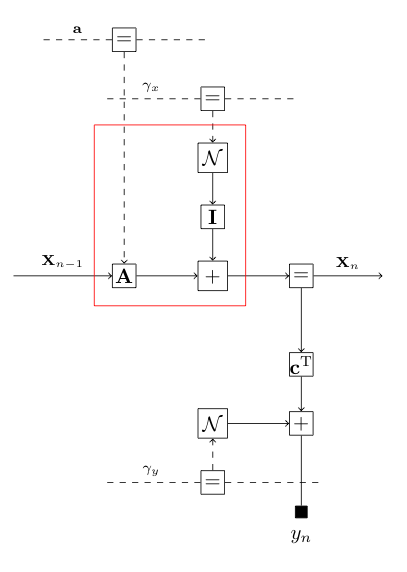

In [27]:
using Images
img = load("../ffgs/HAR-online.png")

The central quantity of our interest is a joint estimation of the AR coefficients $\mathbf{a}$ and states $\mathbf{x}_n$, while setting noises' precision $\gamma_x=1$, $\gamma_y=1/2$.

In [28]:
using ProgressMeter
using Revise
using ForneyLab
include( "../AR-node/autoregression.jl")
include("../AR-node/rules_prototypes.jl")
include("../AR-node/vmp_rules.jl")
# helpers for evaluation of the model
include("../helpers/functions.jl")
# module to generate data for AR
include("../data/ARdata.jl")
import Main.ARdata: use_data, generate_data
import LinearAlgebra.I, LinearAlgebra.Symmetric
import ForneyLab: unsafeCov, unsafeMean, unsafePrecision

In [29]:
ARorder = 5 # order of AR model
diagAR(dim) = Matrix{Float64}(I, dim, dim)
x = []
# AR data
a_w = 1.0; b_w = 1.0
process_noise = b_w/a_w
coefs, x = generate_data(1000, ARorder, 1, noise_variance=process_noise)
# Observations
measurement_noise = 2.0
y = [xi[1] + sqrt(measurement_noise)*randn() for xi in x[ARorder:end]]

996-element Array{Float64,1}:
  2.138196315559388  
  2.274792524249742  
  1.2545143127795129 
  3.2791347492816083 
  2.980307004975299  
  2.345937943188322  
  3.762143049031123  
 -1.1183873692404342 
  2.687420768441074  
  1.590075312913208  
 -0.23179447935906639
  1.8537891821930939 
 -1.3807561884153874 
  ⋮                  
  1.6769670536163688 
  2.509391982902433  
  3.7057079126166776 
  3.3189699623977442 
  4.1772476257663635 
  6.432294970644159  
  6.913294288476758  
  3.908869337878622  
  5.2389795546283935 
  2.992348620874291  
  0.8645527684029828 
  4.3860246997298935 

In [30]:
# Building the model
g = FactorGraph()

# declare priors as random variables
@RV m_x_t_prev
@RV w_x_t_prev
@RV m_a_t
@RV w_a_t
@RV m_y_t

@RV a ~ GaussianMeanPrecision(m_a_t, w_a_t)
@RV x_t_prev ~ GaussianMeanPrecision(m_x_t_prev, w_x_t_prev)
@RV w ~ Gamma(a_w, b_w)
@RV x_t = AR(a, x_t_prev, w)
c = zeros(ARorder); c[1] = 1.0
@RV y_t ~ GaussianMeanPrecision(m_y_t, measurement_noise^-1)
DotProduct(y_t, c, x_t)

# Placeholders for prior
placeholder(m_x_t_prev, :m_x_t_prev, dims=(ARorder,))
placeholder(w_x_t_prev, :w_x_t_prev, dims=(ARorder, ARorder))
placeholder(m_a_t, :m_a_t, dims=(ARorder,))
placeholder(w_a_t, :w_a_t, dims=(ARorder, ARorder))

# Placeholder for data
placeholder(m_y_t, :m_y_t)

ForneyLab.draw(g)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 14433697115255983840 -->
 
 14433697115255983840 
 
 Gam 
 gamma_1 
 
<!-- 5335464383541974748 -->
 
 5335464383541974748 
 
 clamp_2 
 
<!-- 14433697115255983840--5335464383541974748 -->
 
 14433697115255983840--5335464383541974748 
 
 clamp_2 
 1 out 
 3 b 
 
<!-- 14088518629179412034 -->
 
 14088518629179412034 
 
 clamp_1 
 
<!-- 14433697115255983840--14088518629179412034 -->
 
 14433697115255983840--14088518629179412034 
 
 clamp_1 
 1 out 
 2 a 
 
<!-- 7956144485828015506 -->
 
 7956144485828015506 
 
 placeholder_m_x_t_prev 
 
<!-- 12274730484637961004 -->
 
 12274730484637961004 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 7956144485828015506--12274730484637961004 -->
 
 7956144485828015506--12274730484637961004 
 
 m_x_t_prev 
 2 m 
 1 out 
 
<!-- 5128476377048740251 -->
 
 5128476377048740251 
 
 placeholder_w_a_t 
 
<!-- 15981390683477897811 -->
 
 15981390683477897811 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 5128476377048740251--15981390683477897811 -->
 
 5128476377048740251--15981390683477897811 
 
 w_a_t 
 3 w 
 1 out 
 
<!-- 7994034502647363292 -->
 
 7994034502647363292 
 
 clamp_4 
 
<!-- 7930784108387550428 -->
 
 7930784108387550428 
 
 placeholder_m_y_t 
 
<!-- 1692672407975689180 -->
 
 1692672407975689180 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 7930784108387550428--1692672407975689180 -->
 
 7930784108387550428--1692672407975689180 
 
 m_y_t 
 2 m 
 1 out 
 
<!-- 16878850110610406447 -->
 
 16878850110610406447 
 
 dot 
 dotproduct_1 
 
<!-- 16878850110610406447--7994034502647363292 -->
 
 16878850110610406447--7994034502647363292 
 
 clamp_4 
 1 out 
 2 in1 
 
<!-- 16878850110610406447--1692672407975689180 -->
 
 16878850110610406447--1692672407975689180 
 
 y_t 
 1 out 
 1 out 
 
<!-- 11174507517322368209 -->
 
 11174507517322368209 
 
 Autoregression 
 autoregression_1 
 
<!-- 16878850110610406447--11174507517322368209 -->
 
 16878850110610406447--11174507517322368209 
 
 x_t 
 1 out 
 3 in2 
 
<!-- 5233804529419829558 -->
 
 5233804529419829558 
 
 clamp_3 
 
<!-- 1692672407975689180--5233804529419829558 -->
 
 1692672407975689180--5233804529419829558 
 
 clamp_3 
 1 out 
 3 w 
 
<!-- 11174507517322368209--14433697115255983840 -->
 
 11174507517322368209--14433697115255983840 
 
 w 
 1 out 
 4 W 
 
<!-- 11174507517322368209--12274730484637961004 -->
 
 11174507517322368209--12274730484637961004 
 
 x_t_prev 
 1 out 
 2 x 
 
<!-- 11174507517322368209--15981390683477897811 -->
 
 11174507517322368209--15981390683477897811 
 
 a 
 1 out 
 3 a 
 
<!-- 5272672003486855024 -->
 
 5272672003486855024 
 
 placeholder_w_x_t_prev 
 
<!-- 5272672003486855024--12274730484637961004 -->
 
 5272672003486855024--12274730484637961004 
 
 w_x_t_prev 
 3 w 
 1 out 
 
<!-- 3331097122636625878 -->
 
 3331097122636625878 
 
 placeholder_m_a_t 
 
<!-- 3331097122636625878--15981390683477897811 -->
 
 3331097122636625878--15981390683477897811 
 
 m_a_t 
 2 m 
 1 out

In [31]:
# Specify recognition factorization
q = RecognitionFactorization(a, x_t, ids=[:A :X_t])

# Generate the variational update algorithms for each recognition factor
algo = variationalAlgorithm(q)

# Load algorithms
eval(Meta.parse(algo))

stepX_t! (generic function with 3 methods)

In [32]:
# Define values for prior statistics
m_a_0 = 1.0*randn(ARorder)
w_a_0 = (tiny*diagAR(ARorder))
m_x_prev_0 = 1.0*randn(ARorder)
w_x_prev_0 = (0.0001*diagAR(ARorder))

# Storage
m_x_prev = Vector{Vector{Float64}}(undef, length(y))
w_x_prev = Vector{Array{Float64, 2}}(undef, length(y))
m_a = Vector{Vector{Float64}}(undef, length(y))
w_a = Vector{Array{Float64, 2}}(undef, length(y))

# Inits
m_x_t_prev_min = m_x_prev_0
w_x_t_prev_min = w_x_prev_0
m_a_t_min = m_a_0
w_a_t_min = w_a_0;

In [33]:
marginals = Dict()
# VMP iterations
n_its = 10

p = Progress(length(y), 1, "Observed ")
for t in 1:length(y)
    update!(p, t)
    marginals[:a] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_a_t_min, w=w_a_t_min)
    marginals[:x_t_prev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_x_t_prev_min, w=w_x_t_prev_min)
    marginals[:w] = ProbabilityDistribution(Univariate, Gamma, a=a_w, b=b_w)
    global m_x_t_prev_min, w_x_t_prev_min, m_a_t_min, w_a_t_min

    for i = 1:n_its
        data = Dict(:m_y_t => y[t],
                    :m_a_t => m_a_t_min,
                    :w_a_t => w_a_t_min,
                    :m_x_t_prev => m_x_t_prev_min,
                    :w_x_t_prev => w_x_t_prev_min)
        stepX_t!(data, marginals)
        stepA!(data, marginals)
        m_a[t] = unsafeMean(marginals[:a])
        w_a[t] = unsafePrecision(marginals[:a])
        m_x_prev[t] = unsafeMean(marginals[:x_t])
        w_x_prev[t] = unsafePrecision(marginals[:x_t])
        m_a_t_min = m_a[t]
        w_a_t_min = w_a[t]
        m_x_t_prev_min = m_x_prev[t]
        w_x_t_prev_min = w_x_prev[t]
    end
end

Observed 100%|██████████████████████████████████████████| Time: 0:00:02


In [34]:
# MSE analysis
from = 1
estimated = [x[1] for x in m_x_prev[from:end]]
real = [x[1] for x in x[ARorder:end]]
noise = [y[1] for y in y[from:end]]

println("Δ(estimated, real)=", mse(estimated, real))
println("Δ(estimated, noise)=", mse(estimated, noise))
println("Δ(noise, actual)=", mse(noise, real))

Δ(estimated, real)=2.8071783396095595
Δ(estimated, noise)=3.3681814819216154
Δ(noise, actual)=1.9303097299200782


In [35]:
using Plots

scale = 1.0 # scale for the variance
v_x = [v_x[1]^-1 for v_x in w_x_prev[1:end]] # variances of estimated state
toshow = 10 # number of points to plot at once

anim = @animate for i in 1:length(estimated)-toshow
    s = plot(xticks = i:div(toshow, 2):i+toshow);
    ylims!(minimum(noise) - .1, maximum(noise) + .1);
    scatter!(collect(i:i+toshow), noise[i:i+toshow], label="noisy observations", 
            markershape = :xcross, markeralpha = 0.6,
            markersize = 2)
    
    plot!(collect(i:i+toshow), [estimated[i:i+toshow], estimated[i:i+toshow]], fillrange=[estimated[i:i+toshow] -
          scale .* sqrt.(v_x[i:i+toshow]), estimated[i:i+toshow] + scale .* sqrt.(v_x[i:i+toshow])],
          linestyle=:dash, linewidth = 2,
          color=:black,
          fillalpha = 0.2,
          fillcolor = :red,
          label="inferred")
    
    plot!(collect(i:i+toshow), real[i:i+toshow], color = :magenta, linewidth = 1.0, label="real state")
end

Animation("/var/folders/8n/rnpdqdwj53nd09r6r7qwc_bc0000gn/T/tmpKQxaDy", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000977.png", "000978.png", "000979.png", "000980.png", "000981.png", "000982.png", "000983.png", "000984.png", "000985.png", "000986.png"])

In [37]:
gif(anim, "../gifs/KMPstate.gif", fps = 10)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Desktop/VMP-AR/gifs/KMPstate.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/QYETN/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Desktop/VMP-AR/gifs/KMPstate.gif")

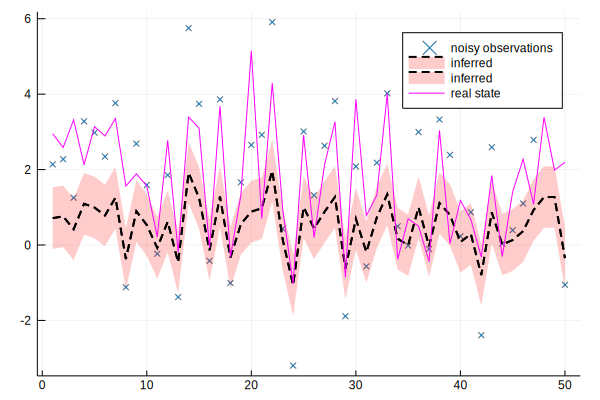

In [38]:
# Plotting
using Plots
upto = 50 # limit for building a graph
scale = 1.0 # scale for the variance
v_x = [v_x[1]^-1 for v_x in w_x_prev[1:end]] # variances of estimated state
scatter(noise[1:upto], label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!([estimated[1:upto], estimated[1:upto]], fillrange=[estimated[1:upto] -
      scale .* sqrt.(v_x[1:upto]), estimated[1:upto] +
      scale .* sqrt.(v_x[1:upto])],
      linestyle=:dash,linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :red,
      label=["inferred", "inferred"])
plot!(real[1:upto], color = :magenta, linewidth = 1.0, label="real state")